# The Models

## Customized Callback

In [30]:
from ultralytics.utils import SETTINGS
SETTINGS.update({"tensorboard": True})


In [2]:
from ultralytics import YOLO
import torch

def on_fit_epoch_end(trainer):
    m = trainer.metrics or {}
    ep = trainer.epoch + 1
    # Keys are consistent across YOLOv8/11: metrics for best (B) model at epoch
    mp50    = float(m.get("metrics/mAP50(B)", 0.0))
    mp5095  = float(m.get("metrics/mAP50-95(B)", 0.0))
    prec    = float(m.get("metrics/precision(B)", 0.0))
    rec     = float(m.get("metrics/recall(B)", 0.0))
    # train losses if available
    box = getattr(trainer, "tloss_box", None)
    cls = getattr(trainer, "tloss_cls", None)
    dfl = getattr(trainer, "tloss_dfl", None)
    print(f"[E{ep:03d}] mAP50={mp50:.3f}  mAP50-95={mp5095:.3f}  P={prec:.3f}  R={rec:.3f}  "
          f"box={float(box) if box is not None else 'NA'}  "
          f"cls={float(cls) if cls is not None else 'NA'}  "
          f"dfl={float(dfl) if dfl is not None else 'NA'}")

## BaseModel

In [ ]:
# Define augmentation settings for training
AUG_BALANCED = dict(
    hsv_h=0.015, hsv_s=0.70, hsv_v=0.40,  # HSV color augmentation
    degrees=10, translate=0.10, scale=0.50, shear=2.0, perspective=0.0005,  # geometric transformations
    fliplr=0.50, flipud=0.00,  # flip horizontally with 50% chance
    mosaic=0.80, mixup=0.10, copy_paste=0.00  # advanced augmentations
)

# Load YOLO model
model = YOLO('yolo11s.pt')

# Add a custom callback (e.g., for logging or evaluation)
model.add_callback("on_fit_epoch_end", on_fit_epoch_end)

# Start training with defined parameters and augmentations
model.train(
    data='Yolo_model_and_data/Student-Attention-Tracker/data.yaml',  # path to dataset config
    epochs=50,               # number of training epochs
    batch=-1,                # use auto batch size
    imgsz=640,               # image size
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),  # use best available device
    project="runs",          # project folder for results
    name="y11_sgd",          # name of this run
    cache="ram",             # cache dataset in RAM
    amp=True,                # use automatic mixed precision
    workers=4,               # number of data loading workers
    rect=True,               # use rectangular training
    save=True,               # save checkpoints
    plots=True,              # generate training plots
    val=True,                # validate during training
    **AUG_BALANCED           # apply augmentations
)


Backend: inline


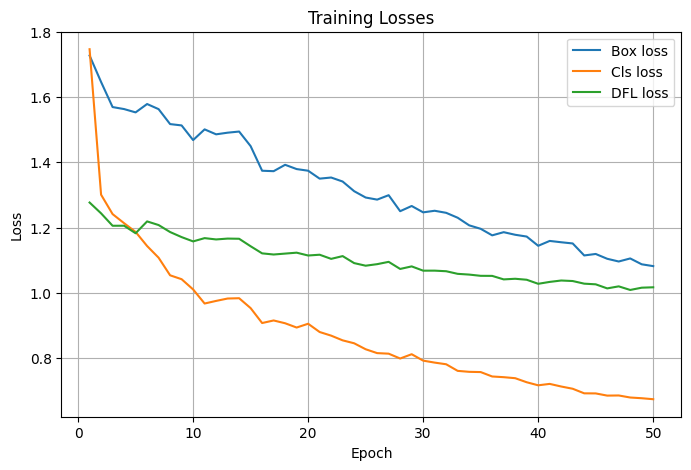

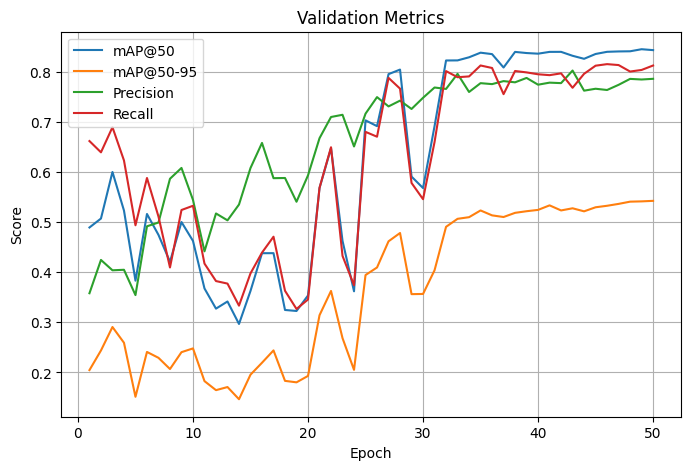

In [17]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
print("Backend:", plt.get_backend())

logfile = 'Yolo_model_and_data/runs/y11_sgd/results.csv'

df = pd.read_csv(logfile)

# Training Losses
plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Box loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Cls loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="DFL loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid(True)
plt.show()

# Validation Metrics
plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95")
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.legend()
plt.grid(True)
plt.show()


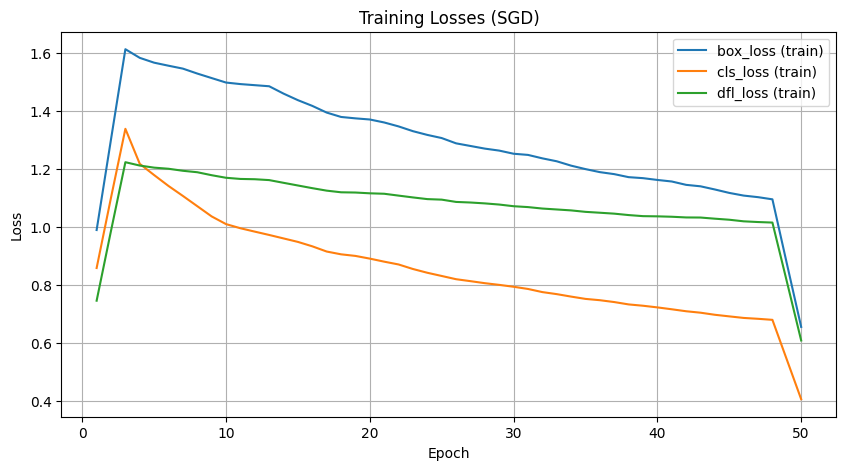

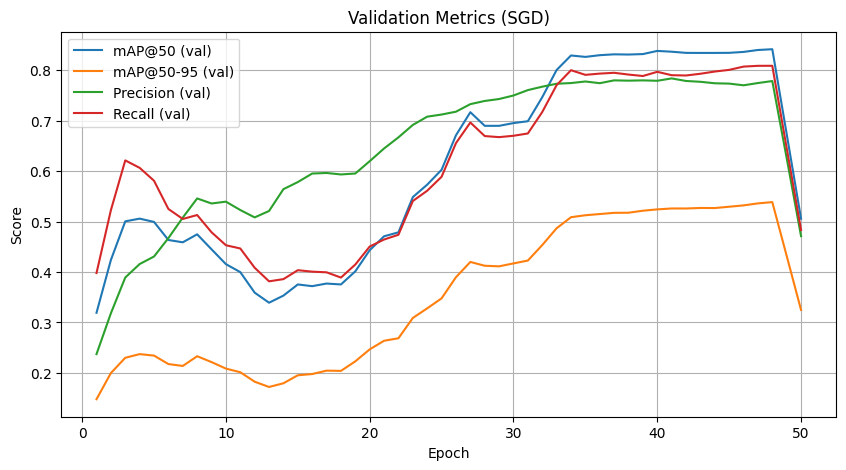

Best val mAP50-95 at epoch 50: 0.542
No overfitting detected.


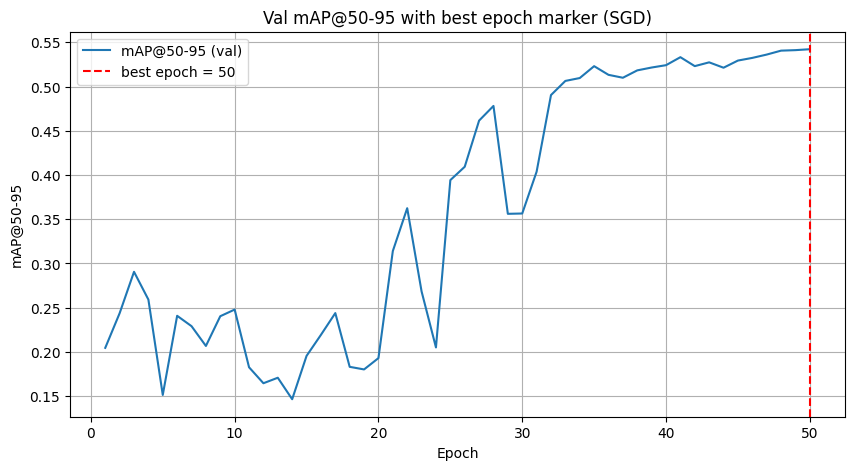

In [19]:
LOG ='Yolo_model_and_data/runs/y11_sgd/results.csv'

df = pd.read_csv(LOG)


# Smooth to see trends better
def smooth(x, k=3):
    if k <= 1: return x.values
    return np.convolve(x.values, np.ones(k) / k, mode="same")


epochs = df["epoch"].values
box = df["train/box_loss"]
cls = df["train/cls_loss"]
dfl = df["train/dfl_loss"]

m50 = df["metrics/mAP50(B)"]
m5095 = df["metrics/mAP50-95(B)"]
prec = df["metrics/precision(B)"]
rec = df["metrics/recall(B)"]

# PLOTS: losses vs metrics
plt.figure(figsize=(10, 5))
plt.plot(epochs, smooth(box, 5), label="box_loss (train)")
plt.plot(epochs, smooth(cls, 5), label="cls_loss (train)")
plt.plot(epochs, smooth(dfl, 5), label="dfl_loss (train)")
plt.legend();
plt.grid(True);
plt.xlabel("Epoch");
plt.ylabel("Loss")
plt.title("Training Losses (SGD)")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, smooth(m50, 5), label="mAP@50 (val)")
plt.plot(epochs, smooth(m5095, 5), label="mAP@50-95 (val)")
plt.plot(epochs, smooth(prec, 5), label="Precision (val)")
plt.plot(epochs, smooth(rec, 5), label="Recall (val)")
plt.legend();
plt.grid(True);
plt.xlabel("Epoch");
plt.ylabel("Score")
plt.title("Validation Metrics (SGD)")
plt.show()

# SIMPLE OVERFITTING DIAGNOSTIC
# Heuristics:
# - Find epoch where val mAP50-95 peaks.
# - Look at subsequent window: if train losses keep dropping ≥ small epsilon
#   while val mAP50-95 drops by more than a tolerance, call it "overfitting after epoch X".

best_idx = int(np.argmax(m5095.values))
best_epoch = int(epochs[best_idx])
best_m = float(m5095.iloc[best_idx])

# define a small window after the peak to check trend
tail = df[df["epoch"] > best_epoch]
overfit = False
explain = "No overfitting detected."

if len(tail) >= 3:
    # total train loss (scaled just for comparison)
    total_train_loss = (box + cls + dfl)
    # compare mean loss & val mAP in windows before vs after the peak
    pre_win = df[(df["epoch"] >= max(0, best_epoch - 3)) & (df["epoch"] <= best_epoch)]
    post_win = df[(df["epoch"] > best_epoch) & (df["epoch"] <= best_epoch + 5)]

    if len(pre_win) > 0 and len(post_win) > 0:
        pre_loss = pre_win[["train/box_loss", "train/cls_loss", "train/dfl_loss"]].sum(axis=1).mean()
        post_loss = post_win[["train/box_loss", "train/cls_loss", "train/dfl_loss"]].sum(axis=1).mean()
        pre_m = pre_win["metrics/mAP50-95(B)"].mean()
        post_m = post_win["metrics/mAP50-95(B)"].mean()

        loss_change = pre_loss - post_loss  # positive = training loss went DOWN (good)
        map_change = post_m - pre_m  # negative = val mAP went DOWN (bad)

        # thresholds: tweak if needed
        if loss_change > 0.01 and map_change < -0.01:
            overfit = True
            explain = (f"Possible overfitting after epoch {best_epoch}: "
                       f"train loss kept decreasing (Δloss={loss_change:.3f}) "
                       f"while val mAP50-95 dropped (ΔmAP={map_change:.3f}).")

print(f"Best val mAP50-95 at epoch {best_epoch}: {best_m:.3f}")
print(explain)

# Optional: mark the best epoch on the val plot for quick eyeballing
plt.figure(figsize=(10, 5))
plt.plot(epochs, m5095, label="mAP@50-95 (val)")
plt.axvline(best_epoch, color="r", linestyle="--", label=f"best epoch = {best_epoch}")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("mAP@50-95")
plt.title("Val mAP@50-95 with best epoch marker (SGD)")
plt.show()


In [14]:
# Load the best trained model checkpoint
best = "runs/y11_sgd/weights/best.pt"
model = YOLO(best)

print("\n=== TRAIN (standard, no TTA) ===")

# Evaluate on the validation set (no TTA)
val_metrics = model.val(
    data='/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/data.yaml',
    split="val",       # use validation split
    imgsz=640,
    rect=True,         # use rectangular inference
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")       # use Apple Metal if available
)
print(val_metrics)

# Evaluate on the test set (no TTA)
print("\n=== TEST (standard, no TTA) ===")
test_metrics = model.val(
    data='/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/data.yaml',
    split="test",      # use test split
    imgsz=640,
    rect=True,
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
)



=== TRAIN (standard, no TTA) ===
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.3.1 MPS (Apple M4)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 687.9±225.9 MB/s, size: 179.3 KB)
val: Scanning /Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/valid/labels.cache... 69 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 69/69 167480.9it/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.00it/s 5.0s
                   all         69       1499      0.786      0.812      0.843      0.542
             Attentive         69       1098      0.862      0.911      0.919      0.604
            Distracted         68        401       0.71      0.713      0.767       0.48
Speed: 0.4ms preprocess, 8.7ms inference, 0.0ms loss, 10.9ms postprocess per image
Results saved to runs/detect/val56
ultralytics.utils.metrics.DetMetri

In [22]:
from ultralytics import YOLO

best = "/Users/khalid/DS_Projects/Yolo_model_and_data/runs/y11_sgd_finetune_ADAMW/weights/best.pt"
data = "/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/data.yaml"

model = YOLO(best)

def run_eval(split):
    metrics = model.val(
        model=best, data=data, imgsz=640, split=split,
        verbose=False, plots=False, save_json=False, save_txt=False, save_hybrid=False
    )
    d = metrics.results_dict
    print(f"\n=== {split.upper()} (concise) ===")
    print(f"Precision:   {d['metrics/precision(B)']:.3f}")
    print(f"Recall:      {d['metrics/recall(B)']:.3f}")
    print(f"mAP@50:      {d['metrics/mAP50(B)']:.3f}")
    print(f"mAP@50-95:   {d['metrics/mAP50-95(B)']:.3f}")
    for cls_i, ap50 in enumerate(metrics.maps):
        print(f"AP50[{metrics.names[cls_i]}]: {ap50:.3f}")

# Run on all splits
for split in ["train", "test"]:
    run_eval(split)


WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.3.1 CPU (Apple M4)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 536.4±273.7 MB/s, size: 191.7 KB)
val: Scanning /Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/train/labels.cache... 333 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 333/333 927425.8it/s 0.0s.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 21/21 0.22it/s 1:34s
                   all        333       7002      0.865      0.868      0.912       0.64
Speed: 0.4ms preprocess, 272.0ms inference, 0.0ms loss, 0.5ms postprocess per image

=== TRAIN (concise) ===
Precision:   0.865
Recall:      0.868
mAP@50:      0.912
mAP@50-95:   0.640
AP50[Attentive]: 0.662
AP50[Distracted]: 0.617
WARNING ⚠️ 'save_hybrid' is deprecated and will 

## Fine Tuning Base Model

In [9]:
# Final light augmentation settings for fine-tuning
AUG_FINISH = dict(
    hsv_h=0.010, hsv_s=0.40, hsv_v=0.25,        # subtle color adjustments
    degrees=3, translate=0.05, scale=0.30, shear=0.5, perspective=0.0002,  # small geometric changes
    fliplr=0.25, flipud=0.00,                   # slight chance of horizontal flip
    mosaic=0.00, mixup=0.00, copy_paste=0.00    # no heavy augmentations for final stage
)


In [10]:
# Custom callback to log key metrics and losses at the end of each epoch
def on_fit_epoch_end(trainer):
    m = trainer.metrics or {}              # get current epoch metrics
    ep = trainer.epoch + 1                 # current epoch number (1-based)

    # Extract performance metrics
    mp50   = float(m.get("metrics/mAP50(B)", 0.0))
    mp5095 = float(m.get("metrics/mAP50-95(B)", 0.0))
    prec   = float(m.get("metrics/precision(B)", 0.0))
    rec    = float(m.get("metrics/recall(B)", 0.0))

    # Extract loss values
    losses = getattr(trainer, "tloss", {})
    box = losses.get("box", float("nan"))
    cls = losses.get("cls", float("nan"))
    dfl = losses.get("dfl", float("nan"))

    # Print summary for the current epoch
    print(f"[E{ep:03d}] mAP50={mp50:.3f}  mAP50-95={mp5095:.3f}  P={prec:.3f}  R={rec:.3f}  "
          f"box_loss={box:.4f} cls_loss={cls:.4f} dfl_loss={dfl:.4f}")


### Using SGD-15 Epochs

In [ ]:
# Load previously trained best model
BEST = "runs/y11_sgd/weights/best.pt"
model = YOLO(BEST)

# Fine-tune the model with lighter augmentations and lower learning rate
model.train(
    data="Yolo_model_and_data/Student-Attention-Tracker/data.yaml",  # dataset path
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),          # use Apple Metal backend
    imgsz=640,             # input image size
    epochs=15,             # fine-tune for 15 epochs
    batch=-1,              # auto batch size
    lr0=1e-3,              # lower initial learning rate
    optimizer="SGD",       # use SGD optimizer
    rect=True,             # rectangular training mode
    amp=True,              # enable mixed precision
    cache="ram",           # cache data in RAM
    workers=2,             # number of data loading workers
    patience=8,            # early stopping if no improvement
    project="runs",        # project folder
    name="y11_sgd_finetune_SGD",  # name of run folder
    **AUG_FINISH           # apply final-stage augmentations
)



In [6]:
# Path to fine-tuned model weights
best = "runs/y11_sgd_finetune_SGD/weights/best.pt"

# Load fine-tuned model
print("\n=== TRAIN (best.pt) — Fine-tuned ===")
model = YOLO(best)

# Evaluate on validation set
model.val(
    model=best,
    data='/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/data.yaml',
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),
    imgsz=640,
    rect=True,
    split="train"  # validation split
)

# Evaluate on test set
print("\n=== TEST (best.pt) — Fine-tuned ===")
model.val(
    model=best,
    data='/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/data.yaml',
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),
    imgsz=640,
    rect=True,
    split="test"  # test split
)


=== TRAIN (best.pt) — Fine-tuned ===
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.3.1 MPS (Apple M4)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 461.9±146.0 MB/s, size: 162.4 KB)
val: Scanning /Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/train/labels.cache... 333 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 333/333 1207176.5it/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 21/21 1.1it/s 19.9s
                   all        333       7002      0.847       0.85      0.897      0.617
             Attentive        333       5009      0.865       0.93      0.933      0.644
            Distracted        326       1993       0.83      0.771       0.86       0.59
Speed: 0.3ms preprocess, 8.1ms inference, 0.0ms loss, 10.8ms postprocess per image
Results saved to runs/detect/val42

=== TEST (best.pt) — Fi

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x30d523390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### Using ADAMW-15 Epochs

In [ ]:
# Load best weights from previous SGD training
model = YOLO('runs/y11_sgd/weights/best.pt')  # load best SGD weights

# Attach custom logging callback
model.add_callback("on_fit_epoch_end", on_fit_epoch_end)

# Fine-tune using AdamW and lighter augmentations
model.train(
    data='Yolo_model_and_data/Student-Attention-Tracker/data.yaml',  # dataset config
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),             # use Apple Metal
    imgsz=640,                # image size
    epochs=15,                # short fine-tune
    batch=-1,                 # auto batch size
    lr0=5e-4,                 # lower LR for polishing
    optimizer="AdamW",        # AdamW optimizer (more stable)
    rect=True,                # use rectangular batches
    cache="ram",              # RAM caching
    amp=True,                 # mixed precision
    workers=2,                # data loader workers
    patience=8,               # early stopping
    project="runs",           # output directory
    name='y11_sgd3_finetune', # run name
    **AUG_FINISH              # final augmentations
)


In [9]:
# Path to best model after AdamW fine-tuning
best = "runs/y11_sgd_finetune_ADAMW/weights/best.pt"

# Load the fine-tuned model
print("\n=== TRAIN (best.pt) — Fine-tuned ===")
model = YOLO(best)

# Evaluate on the validation set
model.val(
    model=best,
    data='/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/data.yaml',
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),
    imgsz=640,
    rect=True,
    split="train"
)

# Evaluate on the test set
print("\n=== TEST (best.pt) — Fine-tuned ===")
model.val(
    model=best,
    data='/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/data.yaml',
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),
    imgsz=640,
    rect=True,
    split="test"
)



=== TRAIN (best.pt) — Fine-tuned ===
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.3.1 MPS (Apple M4)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 514.0±224.0 MB/s, size: 168.2 KB)
val: Scanning /Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/train/labels.cache... 333 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 333/333 893032.8it/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 21/21 0.84it/s 24.9s
                   all        333       7002      0.865      0.868      0.912       0.64
             Attentive        333       5009      0.886      0.921      0.942      0.662
            Distracted        326       1993      0.845      0.814      0.883      0.617
Speed: 0.4ms preprocess, 8.2ms inference, 0.0ms loss, 13.5ms postprocess per image
Results saved to runs/detect/val46

=== TEST (best.pt) — Fi

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x157deed10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Final Fine Tune


In [ ]:
#  Define custom augmentations (mild but targeted)
AUG_DISTRACTED_BOOST = dict(
    hsv_h=0.010, hsv_s=0.40, hsv_v=0.30,     # light color jitter
    degrees=2.0, translate=0.05, scale=0.25, # gentle geometry changes
    shear=0.3, perspective=0.0001,
    fliplr=0.15, flipud=0.00,                # limited flipping
    mosaic=0.00, mixup=0.00, copy_paste=0.00 # disable heavy augmentations
)

#  Load your best-performing model (AdamW fine-tuned)
best_model_path = "runs/y11_sgd_finetune_ADAMW/weights/best.pt"
model = YOLO(best_model_path)
model.add_callback("on_fit_epoch_end", on_fit_epoch_end)  # log after each epoch

#  Train using updated dataset + new samples
model.train(
    data="/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker-1/data.yaml",  # new dataset path
    epochs=20,                  # extended fine-tuning
    lr0=1e-4,                   # very low learning rate
    optimizer="AdamW",          # stable optimizer
    imgsz=640,                  # image size
    batch=-1,                   # auto batch size
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),               # use M1/M2 GPU
    cache="ram",                # load dataset in RAM
    amp=True,                   # mixed precision
    rect=True,                  # rectangular training
    workers=4,                  # dataloader workers
    patience=5,                 # early stopping if no val improvement
    val=True,                   # run validation
    save=True,                  # save checkpoints
    plots=True,                 # save training plots
    name="y11_adamw_finalboost",# run name
    **AUG_DISTRACTED_BOOST      # apply custom augmentations
)


In [10]:
# 5. Evaluate model

# Path to final fine-tuned weights
best = "/Users/khalid/DS_Projects/Yolo_model_and_data/runs/detect/y11_adamw_finalboost/weights/best.pt"

# Load the final model
print("\n=== Final TRAIN (best.pt) — Fine-tuned ===")
model = YOLO(best)

# Run evaluation on validation split
model.val(
    model=best,
    data='/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker-1/data.yaml',
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),
    imgsz=640,
    rect=True,
    split="train"  # validation set
)

# Run evaluation on test split
print("\n=== Final TEST (best.pt) — Fine-tuned ===")
model.val(
    model=best,
    data='/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker-1/data.yaml',
    device="mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),
    imgsz=640,
    rect=True,
    split="test"  # test set
)



=== Final TRAIN (best.pt) — Fine-tuned ===
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.3.1 MPS (Apple M4)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 547.1±174.9 MB/s, size: 207.4 KB)
val: Scanning /Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker-1/train/labels... 412 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 412/412 3815.8it/s 0.1s
val: New cache created: /Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker-1/train/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 26/26 0.84it/s 30.9s
                   all        412       8587      0.866      0.874      0.926      0.645
             Attentive        412       5773      0.862      0.935      0.945      0.668
            Distracted        405       2814      0.871      0.813      0.907      0.621
Speed: 0.6ms preprocess, 10

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x40027a150>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Evaluating All Models

In [ ]:
from ultralytics import YOLO

best = "/Users/khalid/DS_Projects/Yolo_model_and_data/runs/y11_sgd/weights/best.pt"
data = "/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/data.yaml"

model = YOLO(best)

def run_eval(split):
    metrics = model.val(
        model=best, data=data, imgsz=640, split=split,
        verbose=False, plots=False, save_json=False, save_txt=False, save_hybrid=False
    )
    d = metrics.results_dict
    print(f"\n=== {split.upper()} (concise) ===")
    print(f"Precision:   {d['metrics/precision(B)']:.3f}")
    print(f"Recall:      {d['metrics/recall(B)']:.3f}")
    print(f"mAP@50:      {d['metrics/mAP50(B)']:.3f}")
    print(f"mAP@50-95:   {d['metrics/mAP50-95(B)']:.3f}")
    for cls_i, ap50 in enumerate(metrics.maps):
        print(f"AP50[{metrics.names[cls_i]}]: {ap50:.3f}")

# Run on all splits
for split in ["train", "test"]:
    run_eval(split)


In [ ]:
from ultralytics import YOLO

best = "/Users/khalid/DS_Projects/Yolo_model_and_data/runs/y11_sgd_finetune_SGD/weights/best.pt"
data = "/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/data.yaml"

model = YOLO(best)

def run_eval(split):
    metrics = model.val(
        model=best, data=data, imgsz=640, split=split,
        verbose=False, plots=False, save_json=False, save_txt=False, save_hybrid=False
    )
    d = metrics.results_dict
    print(f"\n=== {split.upper()} (concise) ===")
    print(f"Precision:   {d['metrics/precision(B)']:.3f}")
    print(f"Recall:      {d['metrics/recall(B)']:.3f}")
    print(f"mAP@50:      {d['metrics/mAP50(B)']:.3f}")
    print(f"mAP@50-95:   {d['metrics/mAP50-95(B)']:.3f}")
    for cls_i, ap50 in enumerate(metrics.maps):
        print(f"AP50[{metrics.names[cls_i]}]: {ap50:.3f}")

# Run on all splits
for split in ["train", "test"]:
    run_eval(split)


In [ ]:
from ultralytics import YOLO

best = "/Users/khalid/DS_Projects/Yolo_model_and_data/runs/y11_sgd_finetune_ADAMW/weights/best.pt"
data = "/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker/data.yaml"

model = YOLO(best)


def run_eval(split):
    metrics = model.val(
        model=best, data=data, imgsz=640, split=split,
        verbose=False, plots=False, save_json=False, save_txt=False, save_hybrid=False
    )
    d = metrics.results_dict
    print(f"\n=== {split.upper()} (concise) ===")
    print(f"Precision:   {d['metrics/precision(B)']:.3f}")
    print(f"Recall:      {d['metrics/recall(B)']:.3f}")
    print(f"mAP@50:      {d['metrics/mAP50(B)']:.3f}")
    print(f"mAP@50-95:   {d['metrics/mAP50-95(B)']:.3f}")
    for cls_i, ap50 in enumerate(metrics.maps):
        print(f"AP50[{metrics.names[cls_i]}]: {ap50:.3f}")


# Run on all splits
for split in ["train", "test"]:
    run_eval(split)


In [ ]:
from ultralytics import YOLO

best = "/Users/khalid/DS_Projects/Yolo_model_and_data/runs/detect/y11_adamw_finalboost/weights/best.pt"
data = "/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker-1/data.yaml"

model = YOLO(best)


def run_eval(split):
    metrics = model.val(
        model=best, data=data, imgsz=640, split=split,
        verbose=False, plots=False, save_json=False, save_txt=False, save_hybrid=False
    )
    d = metrics.results_dict
    print(f"\n=== {split.upper()} (concise) ===")
    print(f"Precision:   {d['metrics/precision(B)']:.3f}")
    print(f"Recall:      {d['metrics/recall(B)']:.3f}")
    print(f"mAP@50:      {d['metrics/mAP50(B)']:.3f}")
    print(f"mAP@50-95:   {d['metrics/mAP50-95(B)']:.3f}")
    for cls_i, ap50 in enumerate(metrics.maps):
        print(f"AP50[{metrics.names[cls_i]}]: {ap50:.3f}")


# Run on all splits
for split in ["train", "test"]:
    run_eval(split)


## Exporting The Best Model As NCNN

In [1]:
from ultralytics import YOLO

# Load your fine-tuned best model
model = YOLO("runs/detect/y11_adamw_finalboost/weights/best.pt")

# Export to NCNN format
model.export(format="ncnn")

Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.3.1 CPU (Apple M4)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from 'runs/detect/y11_adamw_finalboost/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (18.3 MB)

TorchScript: starting export with torch 2.3.1...
TorchScript: export success ✅ 1.0s, saved as 'runs/detect/y11_adamw_finalboost/weights/best.torchscript' (36.5 MB)

NCNN: starting export with NCNN 1.0.20250503...
WARNING ⚠️ NCNN: PNNX not found. Attempting to download binary file from https://github.com/pnnx/pnnx/.
Note PNNX Binary file must be placed in current working directory or in /Users/khalid/DS_Projects/Yolo_model_and_data/.venv/lib/python3.11/site-packages/ultralytics. See PNNX repo for full installation instructions.
NCNN: successfully found latest PNNX asset file pnnx-20250819-macos.zip
Unzipping pnnx-20250819-macos.zip to /Users/khalid/DS_Projects/Yolo_model_and_data/pnnx-2

pnnxparam = runs/detect/y11_adamw_finalboost/weights/best_ncnn_model/model.pnnx.param
pnnxbin = runs/detect/y11_adamw_finalboost/weights/best_ncnn_model/model.pnnx.bin
pnnxpy = runs/detect/y11_adamw_finalboost/weights/best_ncnn_model/model_pnnx.py
pnnxonnx = runs/detect/y11_adamw_finalboost/weights/best_ncnn_model/model.pnnx.onnx
ncnnparam = runs/detect/y11_adamw_finalboost/weights/best_ncnn_model/model.ncnn.param
ncnnbin = runs/detect/y11_adamw_finalboost/weights/best_ncnn_model/model.ncnn.bin
ncnnpy = runs/detect/y11_adamw_finalboost/weights/best_ncnn_model/model_ncnn.py
fp16 = 0
optlevel = 2
device = cpu
inputshape = [1,3,640,640]f32
inputshape2 = 
customop = 
moduleop = 
get inputshape from traced inputs
inputshape = [1,3,640,640]f32
############# pass_level0
inline module = torch.nn.modules.linear.Identity
inline module = ultralytics.nn.modules.block.Attention
inline module = ultralytics.nn.modules.block.Bottleneck
inline module = ultralytics.nn.modules.block.C2PSA
inline module =

NCNN: export success ✅ 7.4s, saved as 'runs/detect/y11_adamw_finalboost/weights/best_ncnn_model' (36.1 MB)

Export complete (8.7s)
Results saved to /Users/khalid/DS_Projects/Yolo_model_and_data/runs/detect/y11_adamw_finalboost/weights
Predict:         yolo predict task=detect model=runs/detect/y11_adamw_finalboost/weights/best_ncnn_model imgsz=640  
Validate:        yolo val task=detect model=runs/detect/y11_adamw_finalboost/weights/best_ncnn_model imgsz=640 data=/Users/khalid/DS_Projects/Yolo_model_and_data/Student-Attention-Tracker-8/data.yaml  
Visualize:       https://netron.app


'runs/detect/y11_adamw_finalboost/weights/best_ncnn_model'

# Report

In [ ]:
import datetime, time, csv, os, cv2
from collections import Counter

# --- CONFIG ---
MODEL_PATH = "/Users/khalid/DS_Projects/Yolo_model_and_data/runs/detect/y11_adamw_finalboost/weights/best.pt"    # your NCNN model folder
STUDENTS_ENROLLED = 25               # how many students in class
INTERVAL = 10                   # report interval = 30 minutes (in seconds)
FRAME_INTERVAL = 5                   # seconds between frames (set 3 if needed)
CSV_FILENAME = "reports.csv"         # all reports saved here

# --- INIT ---
model = YOLO(MODEL_PATH, task="detect")


# Check if we are inside bootcamp hours
def is_class_time():
    now = datetime.datetime.now()
    start_morning = now.replace(hour=10, minute=0, second=0, microsecond=0)
    end_morning = now.replace(hour=12, minute=0, second=0, microsecond=0)
    start_afternoon = now.replace(hour=13, minute=0, second=0, microsecond=0)
    end_afternoon = now.replace(hour=12, minute=0, second=0, microsecond=0)

    # return (start_morning <= now < end_morning) or (start_afternoon <= now < end_afternoon)
    return True

# Generate the half-hour summary report
def generate_report(detections, enrolled_students):
    now = datetime.datetime.now()
    start_time = now.replace(minute=(now.minute // 30) * 30, second=0, microsecond=0)
    end_time = start_time + datetime.timedelta(minutes=30)

    # Use averages across frames, not majority label counts
    attentive_rate = sum(d['attentive_pct'] for d in detections) / len(detections) if detections else 0
    distracted_rate = sum(d['distracted_pct'] for d in detections) / len(detections) if detections else 0

    # Attendance capped at 100%
    raw_attendance = (sum(d['students'] for d in detections) / (enrolled_students * len(detections)) * 100) if detections else 0
    attendance_pct = min(raw_attendance, 100)

    report = {
        "date": start_time.date().isoformat(),
        "day_of_week": start_time.strftime("%A"),
        "start_time": start_time.strftime("%H:%M"),
        "end_time": end_time.strftime("%H:%M"),
        "students_enrolled": enrolled_students,
        "avg_students_no": int(round(sum(d['students'] for d in detections) / len(detections))) if detections else 0,
        "max_students_no": int(max((d['students'] for d in detections), default=0)),
        "min_students_no": int(min((d['students'] for d in detections), default=0)),
        "attendance_pct": int(round(attendance_pct)),
        "avg_attention_rate": int(round(attentive_rate)),
        "max_attention_rate": int(round(max((d['attentive_pct'] for d in detections), default=0))),
        "min_attention_rate": int(round(min((d['attentive_pct'] for d in detections), default=0))),
        "avg_distraction_rate": int(round(distracted_rate)),
        "max_distraction_rate": int(round(max((d['distracted_pct'] for d in detections), default=0))),
        "min_distraction_rate": int(round(min((d['distracted_pct'] for d in detections), default=0))),
    }
    return report


# Save the report as a row in CSV
def save_report_csv(report, filename):
    file_exists = os.path.isfile(filename)
    with open(filename, "a", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=report.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(report)
    print(f" Report saved for {report['start_time']}–{report['end_time']}")
    print(report)


# Main Loop
def main():
    while True:
        if not is_class_time():
            print("⏸ Not class time, waiting...")
            time.sleep(60)  # check every minute
            continue

        start_time = time.time()
        detections = []

        while time.time() - start_time < INTERVAL and is_class_time():
            # Capture frame from camera
            cap = cv2.VideoCapture('/Users/khalid/DS_Projects/Capstone/Data/4k/clip_rest2_000.MOV')  # Pi camera (change if needed)
            ret, frame = cap.read()
            cap.release()
            if not ret:
                print("️ Could not read frame from camera")
                continue

            # Run YOLO inference
            results = model(
                frame,
                imgsz=640,
                conf=0.5,
                iou=0.4,
                agnostic_nms=True,
                classes=[0, 1],
                max_det=25
            )

            frame_data = {"students": 0, "attentive_pct": 0, "distracted_pct": 0, "label": None}

            for r in results:
                labels = [model.names[int(b.cls)] for b in r.boxes]

                if labels:
                    c = Counter(labels)
                    detected_students = min(sum(c.values()), STUDENTS_ENROLLED)
                    frame_data["students"] = detected_students

                    if detected_students > 0:
                        frame_data["attentive_pct"] = (c.get("Attentive", 0) / detected_students * 100)
                        frame_data["distracted_pct"] = (c.get("Distracted", 0) / detected_students * 100)

                    frame_data["label"] = max(c, key=c.get)

            detections.append(frame_data)
            print(f"Frame: {frame_data['students']} students → "
                  f"{int(round(frame_data['attentive_pct']))}% Attentive, "
                  f"{int(round(frame_data['distracted_pct']))}% Distracted")

            time.sleep(FRAME_INTERVAL)

        if detections:
            report = generate_report(detections, STUDENTS_ENROLLED)
            save_report_csv(report, CSV_FILENAME)


if __name__ == "__main__":
    main()


In [ ]:
MODEL_PATH = "/Users/khalid/DS_Projects/Yolo_model_and_data/runs/detect/y11_adamw_finalboost/weights/best.pt"  # or "runs/detect/y11_adamw_finalboost/weights/best.pt"
SOURCE = '/Users/khalid/Downloads/WhatsApp Video 1447-03-07 at 01.13.38.mp4' # 0=webcam, or "video.mp4", or "rtsp://user:pass@ip/stream"

model = YOLO(MODEL_PATH)
names = model.names

gen = model.predict(
    source=SOURCE, stream=True, show=False, save=False,
    conf=0.30, iou=0.60, agnostic_nms=True, imgsz=960, device="mps", vid_stride=1,show_labels=False,line_thickness=1
)

for r in gen:
    frame = r.orig_img
    annotated = r.plot()  # draws boxes/labels

    # Count classes
    cls = r.boxes.cls.int().tolist() if r.boxes is not None else []
    attn = cls.count(0)  # 'Attentive'
    dist = cls.count(1)  # 'Distracted'
    text = f"Attentive: {attn} | Distracted: {dist}"

    cv2.rectangle(annotated, (10, 10), (420, 50), (0, 0, 0), -1)
    cv2.putText(annotated, text, (18, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

    cv2.imshow("Student Attention (YOLO11s)", annotated)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC to quit
        break

cv2.destroyAllWindows()


In [ ]:
model = YOLO("/Users/khalid/DS_Projects/Yolo_model_and_data/runs/detect/y11_adamw_finalboost/weights/best.pt")

for r in model.predict(
    source='/Users/khalid/Downloads/WhatsApp Video 1447-03-07 at 01.13.38.mp4',  # webcam
    stream=True,
    conf=0.30,
    iou=0.60,
    agnostic_nms=True,
    imgsz=640,
    device="mps",
    line_thickness=1,   # thinner boxes
    hide_conf=True,     # no confidence %
    hide_labels=False   # keep class labels
):
    annotated = r.plot(line_width=1, font_size=0.5)  # extra fine control
    cv2.imshow("Classroom Feed", annotated)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cv2.destroyAllWindows()
